In [3]:
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.6 MB/s 
     |████████████████████████████████| 66 kB 4.4 MB/s 


In [4]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 4.7 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 


In [37]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union, NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

import diffrax
import equinox as eqx
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
from jax import grad, jit, vmap, value_and_grad
import optax

from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten, Relu, Tanh,LogSoftmax)
#from jax.experimental import optimizers
from jax.example_libraries import optimizers

In [6]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [7]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x):
        if self._val is None:
            self._val = x
        else:
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [8]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = jnp.where(jnp.absolute(b)> epsilon, b, jnp.full_like(b, fill_value=epsilon)*jnp.sign(b))
    return a/b

In [9]:

batch_size = 256

## 5. Simulation of time series

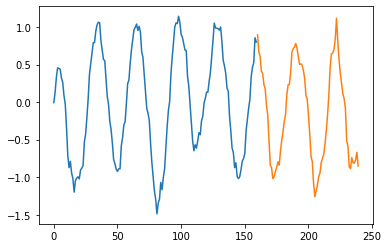

In [10]:
T = 240
t_end = 24.
t_start = 1.
t = np.linspace(t_start,t_end,T)

gap = 160
s = 30
mu = 0
sigma = 0.1
phi = 0.9
def make_time_series():
    z0 = np.random.normal(0,sigma,1)
    z = np.zeros(T)
    z[0] = z0
    shocks = np.random.normal(mu, sigma, T)
    for idx in range(T-1):
        idx_t = t[idx]
        z[idx+1] = phi*z[idx] + shocks[idx] + 0.2*np.sin(2*10*np.pi*(idx_t)/s)
    return z
r = make_time_series()
r_train = r[:gap]
r_test = r[gap:]
plt.plot(range(gap),r_train)
plt.plot(range(gap,T),r_test)
plt.show()


In [11]:
@jit
def make_data():
    ts_ = jnp.array(t)
    ts_ext_ = jnp.array([t_start-0.1] + list(ts_) + [t_end+0.1])
    ts_vis_ = jnp.linspace(t_start,t_end, 1000)
    ys_ = jnp.array(r[:,None])
    return ts_, ts_ext_, ts_vis_, ys_

In [32]:

theta = 1.0
mu = 0.
sigma = 0.001
key = jrandom.PRNGKey(1)
logvar = jnp.log(sigma**2/(2.*theta))

py0_mean = jnp.array([[mu]])
py0_std = jnp.array([[sigma]])
qy0_mean = jnp.array([[mu]])
qy0_logvar = jnp.array([[logvar]])

init_net, net = stax.serial(Dense(200),Tanh,
                           Dense(200),Tanh,
                           Dense(1))
_,net_params = init_net(key,(batch_size,5))
params = [qy0_mean,qy0_logvar] + net_params




def get_std(logvar):
    return jnp.exp(.5 * logvar)

@jit
def loss(params,ts,ys,key):
    zs, kl = forward(ts,batch_size,params,key)
    zs = jnp.squeeze(zs)
    zs = zs[1:-1] 
    logpy = jax.scipy.stats.norm.logpdf(ys,loc=zs,scale=0.0001).sum(axis=0).mean(axis=0)
    loss = -logpy + kl * kl_scheduler.val
    return loss

def forward(ts, batch_size,params,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        print("t",t.shape)
        x = jnp.concatenate((jnp.sin(t),jnp.cos(t),jnp.sin(t**2),jnp.cos(t**2),y),axis=-1)
        print("f'x", x.shape)
        res =net(params[2:],x)
        print("f",res.shape)
        return res


    def g(t, y,args):  # Shared diffusion.
        res = jnp.ones((jnp.size(y,0),1))*sigma
        print("g",res.shape)
        return res

    def h(t, y,args):  # Prior drift.
        #res = jnp.array([theta * (mu - y)])
        res = theta * (mu - y)
        print("h",res.shape)
        return res

    def f_aug(t, y,args):  # Drift for augmented dynamics with logqp term.
        print(y)
        print("f_aug's y shape",y.shape)
        y = y[:,0:1] # 提取第一列，保持列的形态
        print(y)
        fv, gv, hv = f(t, y,args), g(t, y,args), h(t, y,args)
        print("fv",fv.shape)
        print("gv",gv.shape)
        print("hv",hv.shape)
        u = _stable_division(fv - hv, gv) # 计算u(z,t)
        print("u",u.shape)
        f_logqp = .5 * (u ** 2) # 计算integral
        print("f_logpy", f_logqp.shape)
        res = jnp.concatenate([fv, f_logqp],axis=-1)
        print("f_aug",res.shape)
        return res

    def g_aug(t, y,args):  # Diffusion for augmented dynamics with logqp term.
        y = y[:,0:1]
        gv = g(t, y,args)
        g_logqp = jnp.zeros_like(y)
        print("g_logqp",g_logqp.shape)
        res = jnp.concatenate([gv, g_logqp],axis=-1)
        print("g_aug",res.shape)
        return res
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    eps_key,bm_key = jrandom.split(key,2)
    eps = jrandom.normal(key=eps_key,shape=(batch_size,1))
    y0 = qy0_mean + eps * qy0_std
    logqp0 = jnp.log(qy0_std/py0_std+(py0_std**2+(py0_mean-qy0_mean)**2)/(2*qy0_std**2)-0.5)
    logqp0 = logqp0.sum(axis=1)
    aug_y0 = jnp.concatenate([y0, jnp.zeros((batch_size,1))],axis=1)
        
    #control = diffrax.VirtualBrownianTree(t0=ts[0],t1=ts[-1],tol=0.5,shape=(),key=bm_key)
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    #control = diffrax.VirtualBrownianTree(t0=t0,t1=t1,tol=dt0/2,shape=(batch_size,2),key=bm_key)
    control = diffrax.VirtualBrownianTree(t0=t0,t1=t1,tol=dt0/2,shape=(1,2),key=bm_key)
    vf = diffrax.ODETerm(f_aug)
    cvf = diffrax.ControlTerm(g_aug, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    print("aug_y0",aug_y0.shape)
    def integrate(y):
        y = jnp.array([y])
        print("y",y.shape)
        sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y,saveat=saveat)
        return sol.ys
    aug_ys = vmap(integrate,in_axes=(0))(aug_y0).squeeze()
    
    aug_ys = jnp.transpose(aug_ys,axes=(1,0,2))
    print("aug_ys",aug_ys.shape)
    ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
    logqp = (logqp0+logqp_path).mean()
    return ys, logqp
def sample_p(ts, batch_size,eps,control,key):
    
    
    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma

    def h(t, y,args):  # Prior drift.
        return theta * (mu - y)
    
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    y0 = py0_mean + eps * py0_std
    vf = diffrax.ODETerm(h)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

def sample_q(ts, batch_size, params,eps,control,key):
    def f(t, y,args):
        t = jnp.full_like(y, t)
        return net(params[2:],jnp.concatenate((jnp.sin(t),jnp.cos(t),y),axis=-1))

    def g(t, y,args):  # Shared diffusion.
        return jnp.ones((jnp.size(y,0),1))*sigma
    t0 = ts[0]
    t1 = ts[-1]
    dt0 = 0.01
    eps_key,bm_key = jrandom.split(key,2)
    qy0_mean = params[0]
    qy0_std = get_std(params[1])
    y0 = qy0_mean + eps * qy0_std
    vf = diffrax.ODETerm(f)
    cvf = diffrax.ControlTerm(g, control)
    terms = diffrax.MultiTerm(vf,cvf)
    solver = diffrax.Euler()
    saveat=diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(terms, solver, t0,t1,dt0,y0=y0,saveat=saveat,adjoint=diffrax.NoAdjoint())
    return sol.ys

In [33]:
@jit
def update(params, ts, ys, opt_state,key):
    value, grads = value_and_grad(loss)(params,ts,ys,key)
    opt_state = opt_update(0,grads, opt_state)
    return get_params(opt_state),opt_state, value

In [34]:
opt_init, opt_update, get_params = optimizers.adam(1e-2)
opt_state = opt_init(params)
kl_scheduler = LinearScheduler(iters=100)
    
logpy_metric = EMAMetric()
kl_metric = EMAMetric()
loss_metric = EMAMetric()

In [35]:
import torch.distributions
def main(opt_state,num_epochs = 500):
    
    
    ts, ts_ext, ts_vis, ys = make_data()
    p_key,eps_key, bm_key,per_key,k1 = jrandom.split(key,5)
    vis_batch_size = 1024
    ylims = (-1., 1.)
    
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = jrandom.permutation(key=per_key,x=vis_batch_size)
    sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
    fill_color = '#9ebcda'
    mean_color = '#4d004b'
    num_samples = len(sample_colors)
    eps = jrandom.normal(key=eps_key,shape=(vis_batch_size,1))
    control = diffrax.VirtualBrownianTree(t0=ts_vis[0],t1=ts_vis[-1],tol=1e-2/2,shape=(vis_batch_size,1),key=jrandom.PRNGKey(1))
    #control = diffrax.UnsafeBrownianPath(shape=(),key=bm_key)
    sigma = jnp.std(ys)
    params = get_params(opt_state)
    
    # plot prior
    zs = sample_p(ts_vis,batch_size,eps,control,p_key).squeeze()
    zs = jnp.sort(zs,axis=1)
    plt.subplot(frameon=False)
    for alpha, percentile in zip(alphas, percentiles):
        idx = int((1 - percentile) / 2. * vis_batch_size)
        zs_bot = zs[:, idx]
        zs_top = zs[:, -idx]
        
        plt.fill_between(ts_vis, zs_bot, zs_top, alpha=alpha, color=fill_color)

    
    plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
    plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
    #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
    plt.ylim(ylims)
    plt.xlabel('$t$')
    plt.ylabel('$Y_t$')
        
    plt.tight_layout()
    plt.legend()
    #plt.savefig('./img_diffrax/prior.png', dpi=300)
    plt.show()
    plt.close()
    
    # for loop
    for epoch in range(num_epochs):
        if (epoch+1) % 10 == 0:
            img_path = os.path.join("./img_diffrax/", f'global_step_{epoch+1}.png')
            zs = sample_q(ts_vis,batch_size,params,eps,control,p_key).squeeze()
            plt.plot(ts_vis, zs.mean(axis=1), color='r',label=r'mean of latent variables')
            plt.scatter(ts, ys, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.plot(ts, ys, marker='x', zorder=3, color='k',label="observed $r_t$")
            #plt.plot(ts, z[:,None], color='g', linewidth=3.0, label=r"hidden variable $z_t$")
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')

            plt.tight_layout()
            plt.legend()
            #plt.savefig(img_path, dpi=300)
            plt.show()
            plt.close()
        start_time = time.time()
        params, opt_state, loss = update(params, ts_ext,ys, opt_state,k1)
        
        loss_metric.step(loss)
        kl_scheduler.step()
        epoch_time = time.time()-start_time
        print("Epoch {} | T: {:0.2f} | loss {:0.3f}".format(epoch+1,epoch_time,loss))
        



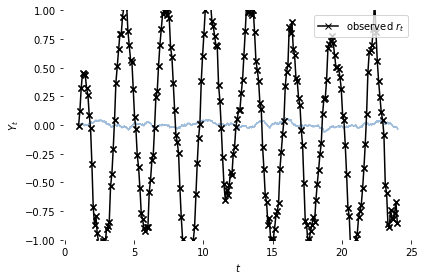

aug_y0 (256, 2)
y (1, 2)
Traced<ShapedArray(float32[1,2])>with<DynamicJaxprTrace(level=9/5)>
f_aug's y shape (1, 2)
Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=9/5)>
t (1, 1)
f'x (1, 5)
f (1, 1)
g (1, 1)
h (1, 1)
fv (1, 1)
gv (1, 1)
hv (1, 1)
u (1, 1)
f_logpy (1, 1)
f_aug (1, 2)
g (1, 1)
g_logqp (1, 1)
g_aug (1, 2)
aug_ys (242, 256, 2)
Epoch 1 | T: 55.97 | loss 5744868864.000
Epoch 2 | T: 35.83 | loss 14064914432.000
Epoch 3 | T: 34.23 | loss 5998172160.000
Epoch 4 | T: 34.33 | loss 5843606016.000
Epoch 5 | T: 35.35 | loss 6003897344.000
Epoch 6 | T: 34.79 | loss 5982942208.000
Epoch 7 | T: 35.23 | loss 5875489280.000
Epoch 8 | T: 35.77 | loss 5785706496.000
Epoch 9 | T: 41.77 | loss 5734918144.000


TypeError: ignored

In [36]:
logging.getLogger().setLevel(logging.INFO)

main(opt_state)